In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.stats import entropy
import sys

In [2]:
n,T=50000,20
batch_size = 128

In [3]:
betas = np.power(np.linspace(0.1,0.5,T),2)
alphas = 1-betas
cumprod_alphas = np.cumprod(alphas)
sqrt_cumprod_alphas = np.sqrt(cumprod_alphas)
sqrt_betas = np.sqrt(betas)
sqrt_alphas = np.sqrt(alphas)
sqrt_one_minus_cumprod_alphas = np.sqrt(1-cumprod_alphas)

In [4]:
x0 = np.random.rand(n)
x = np.zeros(n*T)
t = np.zeros(n*T)
y = np.zeros(n*T)
for i in range(T):
    noise = np.random.randn(n)
    x[n*i:n*(i+1)] = sqrt_cumprod_alphas[i]*x0+sqrt_one_minus_cumprod_alphas[i]*noise
    t[n*i:n*(i+1)] = i+1
    y[n*i:n*(i+1)] = noise

In [5]:
x = np.reshape(x,(n*T,1))
x.shape

(1000000, 1)

In [6]:
# i = 9
# _,ax = plt.subplots(1,3,figsize=(15,5))
# ax[0].hist(x[n*i:n*(i+1)],bins=25)
# ax[0].title.set_text('x - '+str(i+1))
# ax[1].hist(y[n*i:n*(i+1)],bins=25)
# ax[1].title.set_text('y - '+str(i+1))
# ax[2].scatter(x[n*i:n*(i+1)],y[n*i:n*(i+1)])
# ax[2].title.set_text('x vs y - '+str(i+1))
# plt.show()

In [7]:
y_pred = x[n*(T-1):n*T]
y_true = np.random.randn(n)
bin_edges = np.linspace(-3,3,25)
y_pred = np.histogram(y_pred,bins=bin_edges)
y_true = np.histogram(y_true,bins=bin_edges)
entropy(y_true[0],y_pred[0])

0.01587482434898048

In [8]:
x,t,y = shuffle(x,t,y,random_state=0)

In [52]:
input_x = tf.keras.layers.Input(shape=(1,1,))
input_t = tf.keras.layers.Input(shape=(1,))
emb = tf.keras.layers.Embedding(T+1,32)(input_t)
concat = tf.keras.layers.Concatenate(axis=-1)([input_x,emb])
dense_1 = tf.keras.layers.Dense(10,activation=tf.keras.layers.LeakyReLU(alpha=1))(concat)
output = tf.keras.layers.Dense(1,activation=tf.keras.layers.LeakyReLU(alpha=1))(dense_1)
model = tf.keras.Model([input_x,input_t],output)

In [53]:
model.compile(optimizer='Adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [54]:
history = model.fit(x=[x,t],y=y,batch_size=512,epochs=50,callbacks=[callback])

Epoch 1/50
1954/1954 [==============================] - 5s 2ms/step - loss: 1.0005
Epoch 2/50
1954/1954 [==============================] - 5s 2ms/step - loss: 1.0004
Epoch 3/50
1954/1954 [==============================] - 5s 2ms/step - loss: 1.0004
Epoch 4/50
1954/1954 [==============================] - 5s 3ms/step - loss: 1.0003
Epoch 5/50
1954/1954 [==============================] - 5s 2ms/step - loss: 1.0004
Epoch 6/50
1954/1954 [==============================] - 5s 3ms/step - loss: 1.0003
Epoch 7/50
1954/1954 [==============================] - 5s 2ms/step - loss: 1.0003
Epoch 8/50
1954/1954 [==============================] - 5s 2ms/step - loss: 1.0003
Epoch 9/50
1954/1954 [==============================] - 5s 2ms/step - loss: 1.0003
Epoch 10/50
1954/1954 [==============================] - 5s 2ms/step - loss: 1.0003


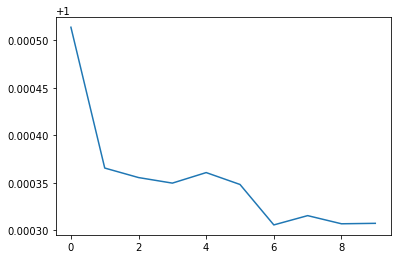

In [55]:
plt.plot(history.history['loss'])
plt.show()

In [56]:
test_size = n
x_pred = np.zeros(test_size*T)
x_pred[test_size*(T-1):test_size*(T)] = x[n*(T-1):n*T,0]
x_pred = np.reshape(x_pred,(test_size*(T),1))

In [57]:
for i in range(T-1,0,-1):
    e = model.predict([x_pred[test_size*(i):test_size*(i+1)],i*np.ones(test_size)])
    x_pred[test_size*(i-1):test_size*(i),0] = (x_pred[test_size*(i):test_size*(i+1),0]-betas[i-1]*e[:,0,0]/sqrt_one_minus_cumprod_alphas[i-1])/sqrt_alphas[i-1]+np.random.randn(test_size,1)[0]*sqrt_betas[i-1]
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*(T-i), 5*(T-i)))
    sys.stdout.flush()

[=================== ] 95%

In [58]:
# _,ax = plt.subplots(2,5,figsize=(25,10))
# for i in range(0,5):
#     ax[0,i].hist(x_pred[test_size*(i):test_size*(i+1),0], bins=25)
#     ax[0,i].title.set_text(str(i))
# for i in range(5,10):
#     ax[1,i-5].hist(x_pred[test_size*(i):test_size*(i+1),0], bins=25)
#     ax[1,i-5].title.set_text(str(i))
# plt.show()

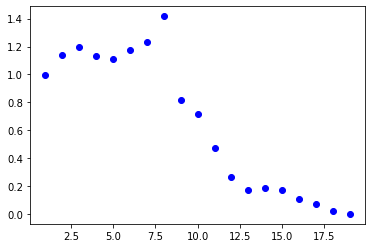

In [59]:
plt_x,plt_y = [],[]
# y_pred = np.histogram(x_pred[0:test_size,0],bins=bin_edges)
# y_true = np.histogram(x0,bins=bin_edges)
# plt_y.append(entropy(y_true[0],y_pred[0]))
# plt_x.append(0)
for i in range(T):
    y_pred = np.histogram(x_pred[test_size*(i+1):test_size*(i+2),0],bins=bin_edges)
    y_true = np.histogram(x[test_size*(i):test_size*(i+1)],bins=bin_edges)
    plt_y.append(entropy(y_true[0],y_pred[0]))
    plt_x.append(i+1)
plt.plot(plt_x,plt_y,'bo')
plt.show()